## Notebook to preprocess data from the Force perturbation center-out (CO) task

### First imports

In [1]:
### Imports

import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers import *
from sklearn.metrics import *

import pickle
import math

import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

from pyaldata import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
data_dir = "./Data"
fname = os.path.join(data_dir, "Chewie_CO_FF_2016-10-07.mat")
name = 'Chewie'
date = '1007'
path_to_save_data = os.path.join(data_dir, 'Processed_Data', 'Tidy_'+name+'_'+str(date)+'.pkl')

In [3]:
# Load TrialData .mat file into a DataFrame
df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

### Start preprocessing

a) For now combining bins to have 20ms instead of 10ms long windows to compute firing rate and velocity. We will see later if it should be done or not but we leave it as it may affect the thresholds for low-firing neurons and other functions.

In [4]:
# Combine time-bins into longer ones
td = combine_time_bins(df, 2)

b) Remove low-firing neurons. This function uses a threshold which is in Hz. 
As the threshold is 5Hz, that means that in 20ms bin we need at least 1 spike.
The function removes all neurons with an average firing rate below the threshold.

`Note` I am not sure if the threshold should be adjusted. With this threshold we remove 23/70 neurons ( so 33% ), whereas in the other dataset it was only 4/64. 

In [5]:
# Remove low-firing neurons
td = remove_low_firing_neurons(td, "M1_spikes",  5, divide_by_bin_size=True, verbose=True)
td = remove_low_firing_neurons(td, "PMd_spikes", 5, divide_by_bin_size=True, verbose=True)
print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

Removed 23 neurons from M1_spikes.
Removed 54 neurons from PMd_spikes.
original:  (359, 70)
removed:   (179, 47)


c) Transform signals to get the SQRT

In [6]:
# Transform signals
td_2 = transform_signal(td, "M1_spikes",  'sqrt')
td_2 = transform_signal(td_2, "PMd_spikes", 'sqrt')

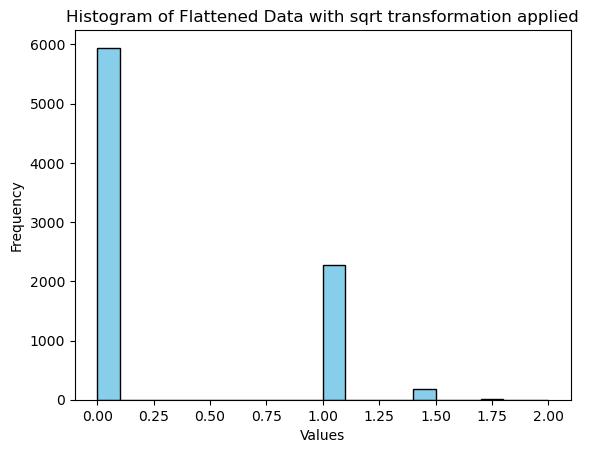

Mean :  0.304  Variance :  0.226


In [7]:
flattened_data_td2 = td_2.M1_spikes[0].flatten()

# Plot histogram
plt.hist(flattened_data_td2, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened Data with sqrt transformation applied')

# Show plot
plt.show()
print('Mean : ' ,np.round(flattened_data_td2.mean(), 3), ' Variance : ', np.round(flattened_data_td2.var(), 3))

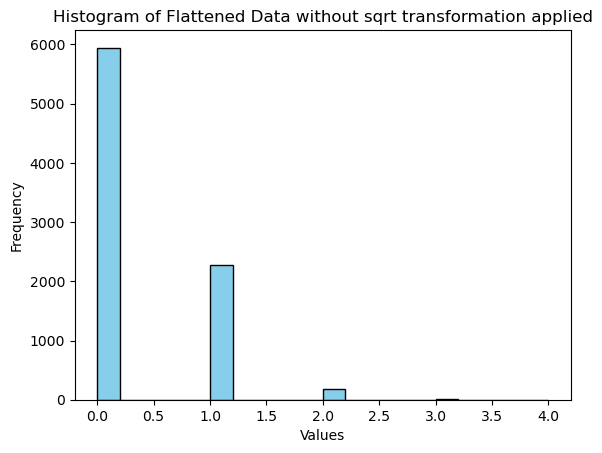

Mean :  0.318  Variance :  0.271


In [8]:
flattened_data = td.M1_spikes[0].flatten()

# Plot histogram
plt.hist(flattened_data, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened Data without sqrt transformation applied')

# Show plot
plt.show()
print('Mean : ' ,np.round(flattened_data.mean(), 3), ' Variance : ', np.round(flattened_data.var(), 3))

Overall, while the square root transformation is not always necessary or appropriate, it can be a valuable preprocessing step for neural data analysis, helping to address issues related to variance stabilization, linearity, and normalization.

d) Merge signals

Signals from the pre-motor and motor cortex are now combines in one same variable,  we do not consider the 2 regions as different but more as functionally working together.


In [9]:
td = merge_signals(td_2, ["M1_spikes", "PMd_spikes"], "both_spikes")

e) Compute firing rates. 

The way this is done is:
- First the std is defined or computed (the default value is 0.05)
- Then the std and the bin size are used to compute the gaussian window
- This window is used to compute a 1d convolution with each train of spikes and hence smooth and compute the firing rates per neuron.

To understand the effect of the window size in the models performances we will compute the firing rates twice, using different std.

In [10]:
# Compute firing rates standard mode
td = add_firing_rates(td, 'smooth', std = 0.05)
td_2 = add_firing_rates(td, 'smooth', std = 0.025)

# Add the variable with the thinner gaussian window to compute the firing rates.
td['both_rates_2'] = td_2['both_rates']  

f) Keep only rewarded trials

In [11]:
td = td.loc[td.result == 'R'].reset_index()

g) Trial length: how to find windows of the same length for the trials?

First idea: check the peak velocity and take values around this point

In [12]:
trial_lengths = [td.vel[i].shape[0] for i in range(len(td.vel))]

In [13]:
min_l = np.min(trial_lengths)
max_l = np.max(trial_lengths)
print('Minimum trial length: ', min_l, ' Maximum trial length : ', max_l)

Minimum trial length:  137  Maximum trial length :  588


In [14]:
indices = [index for index, value in enumerate(trial_lengths) if value < 175]
len(indices)

110

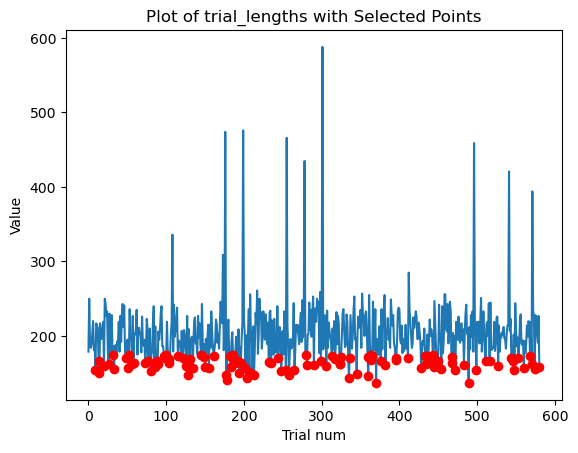

In [15]:
import matplotlib.pyplot as plt

# Plotting trial_lengths
plt.plot(trial_lengths)

# Plotting specific points using indices
plt.plot(indices, [trial_lengths[i] for i in indices], 'ro')  # 'ro' plots red circles

plt.xlabel('Trial num')
plt.ylabel('Value')
plt.title('Plot of trial_lengths with Selected Points')
plt.show()


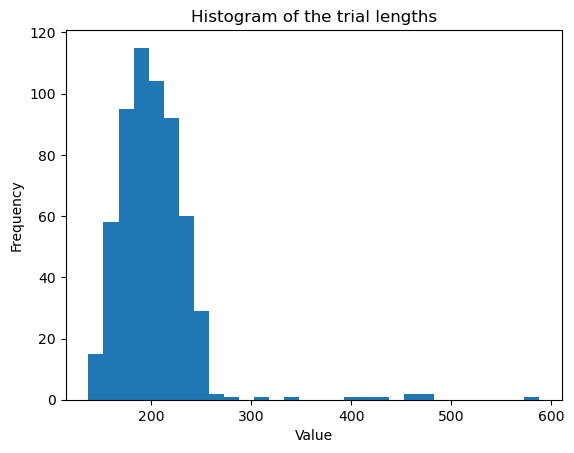

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
data = trial_lengths

# Compute the histogram
hist, bins = np.histogram(data, bins=30)

# Plotting the histogram
plt.hist(data, bins=bins)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the trial lengths')
plt.show()

53


Text(0.5, 1.0, 'Trial split for the different parts of the movement')

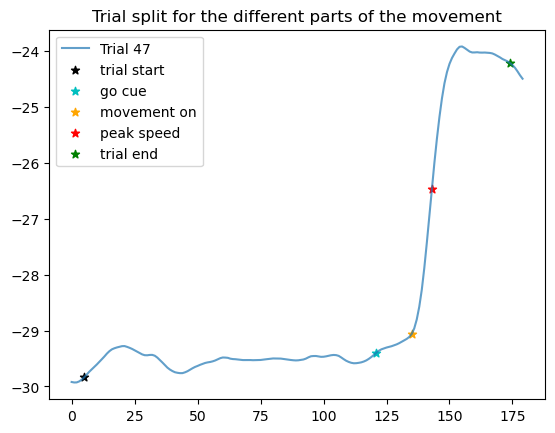

In [17]:
trial_num = 47

plt.plot(td.pos[trial_num][:,1], label = 'Trial ' + str(trial_num), alpha = 0.7)
plt.scatter(td.idx_trial_start[trial_num],td.pos[trial_num][td.idx_trial_start[trial_num],1] , c = 'k', marker= '*', label = 'trial start')
plt.scatter(td.idx_go_cue[trial_num],td.pos[trial_num][td.idx_go_cue[trial_num],1] , c = 'c', marker= '*', label = 'go cue')
plt.scatter(td.idx_movement_on[trial_num],td.pos[trial_num][td.idx_movement_on[trial_num],1] , c = 'orange', marker= '*', label = 'movement on')
plt.scatter(td.idx_peak_speed[trial_num],td.pos[trial_num][td.idx_peak_speed[trial_num],1] , c = 'r', marker= '*', label = 'peak speed')
plt.scatter(td.idx_trial_end[trial_num],td.pos[trial_num][td.idx_trial_end[trial_num],1] , c = 'g', marker= '*', label = 'trial end')
plt.legend()
print(td.idx_trial_end[trial_num] - td.idx_go_cue[trial_num])
plt.title('Trial split for the different parts of the movement')

Most of the movement of interest is between the go cue and the end of the trial. We need to make sure that the distance between those two is not too different from trial to trial and check the maximum distance so we can take the last part of the trials using this value.

In [18]:
dur_trial = [td.idx_trial_end[i] - td.idx_go_cue[i] for i in range(len(td))]
np.max(dur_trial)

75

There is no trial with a distance bigger than 75 samples, so we can say we use the last 100 samples from each trial and we should be able to get all necessary data.

In [19]:
variables_to_cut = ['pos', 'vel', 'M1_rates', 'PMd_rates', 'both_rates', 'both_rates_2']
for i in variables_to_cut:
    td[i] = td[i].apply(lambda x: x[-100:])

Now we want to concatenate all trials one after the other.

In [20]:
td = td.explode(['pos', 'vel', 'M1_rates', 'PMd_rates', 'both_rates', 'both_rates_2']).reset_index()

In [21]:
td.loc[td.trial_id == 5][['trial_id', 'pos', 'vel']].head(3)

,trial_id,pos,vel
200,5,"[0.17819852235245115, -30.055449847498167]","[0.858193349977317, 0.9150490725092748]"
201,5,"[0.1998603841915525, -30.03645001503957]","[1.2472336587016735, 0.8915203018606699]"
202,5,"[0.22581833701365284, -30.019478346993672]","[1.1917484688647204, 0.8710352080699665]"


### Data augmentation for linear decoders

Data augmentation to account for the neural activity up to 100ms before the position/movement. 
We build 5 new timeseries, each one starting 20ms after. We pad the data using the first sample.

In [25]:
tidy_df = td.copy()

In [26]:
tidy_df['both_rates1'] = pd.concat([tidy_df.both_rates[:1], tidy_df.both_rates[:-1]]).reset_index().drop(columns = 'index')
tidy_df['both_rates2'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-2]]).reset_index().drop(columns = 'index')
tidy_df['both_rates3'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-3]]).reset_index().drop(columns = 'index')
tidy_df['both_rates4'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:-4]]).reset_index().drop(columns = 'index')
tidy_df['both_rates5'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1], tidy_df.both_rates[:-5]]).reset_index().drop(columns = 'index')

In [29]:
tidy_df['both_rates_21'] = pd.concat([tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-1]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_22'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],  tidy_df.both_rates_2[:-2]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_23'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],  tidy_df.both_rates_2[:-3]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_24'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-4]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_25'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-5]]).reset_index().drop(columns = 'index')

In [30]:
def extend_cols(x, main_col, cols):
    data = x[main_col]
    for c in cols:
        data = np.concatenate([data, x[c]])
    return data

In [28]:
tidy_df['both_rates_augmented'] = tidy_df[['both_rates', 'both_rates1', 
                                      'both_rates2', 'both_rates3', 
                                      'both_rates4', 'both_rates5']].apply(lambda x: extend_cols(x, 'both_rates', 
                                                                                                   ['both_rates1', 'both_rates2', 
                                                                                                    'both_rates3', 'both_rates4', 
                                                                                                    'both_rates5']), axis = 1)

tidy_df['both_rates_augmented_2'] = tidy_df[['both_rates_2', 'both_rates_21', 
                                      'both_rates_22', 'both_rates_23', 
                                      'both_rates_24', 'both_rates_25']].apply(lambda x: extend_cols(x, 'both_rates_2', 
                                                                                                   ['both_rates_21', 'both_rates_22', 
                                                                                                    'both_rates_23', 'both_rates4', 
                                                                                                    'both_rates_25']), axis = 1)

## Linear Decoder

In [23]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis

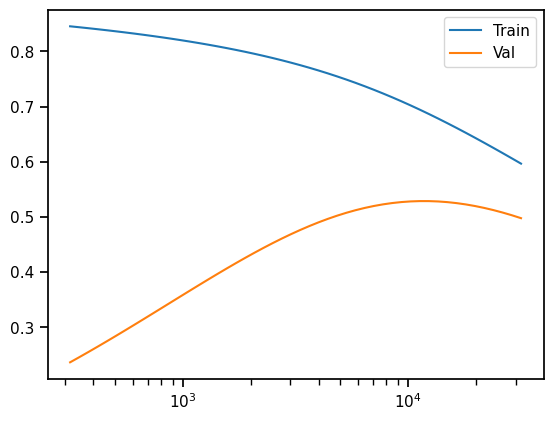

In [ ]:
num_folds = 5
dim_reduce = False
num_dim = 10

alphas = np.logspace(2.5, 4.5, 50)

test_score = []
train_score = []
best_a = []

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None

    for a in alphas:
        if dim_reduce == True:

            PCA_model = PCA(num_dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])
        else:
            X_train_ = X_train['fold'+str(i)]
            X_val_ = X_val['fold'+str(i)]
            X_test_ = X_test['fold'+str(i)]

        model = Ridge(alpha = a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
    if i == 1:
        plt.plot(alphas, train_score_a, label = 'Train')
        plt.plot(alphas, val_score_a, label = 'Val')
        plt.xscale('log')
        plt.legend()

    best_a.append(alphas[np.argmax(val_score_a)])
    test_score.append(best_model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(best_model.score(X_train_, y_train['fold'+str(i)]))
